# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Построим модель с максимально большим значением <b>*accuracy*</b>. Чтобы модель показывала себя успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверим <b>*accuracy*</b> на тестовой выборке.

# Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

    - сalls — количество звонков;
    - minutes — суммарная длительность звонков в минутах;
    - messages — количество sms-сообщений;
    - mb_used — израсходованный интернет-трафик в Мб;
    - is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Загрузка и изучение данных

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

users = pd.read_csv('users_behavior.csv')

In [2]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропущенных значений нет.

In [3]:
users.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


В данных есть пользователи, которые не пользуются, например, звонками, но пользуются остальными услугами, или не пользуются интернетом, но пользуются звонками и т.д.

Пользователей, которые не пользовались услугами вовсе, нет.

In [4]:
users.query('calls == 0 and minutes == 0 and messages == 0 and mb_used == 0')

,calls,minutes,messages,mb_used,is_ultra


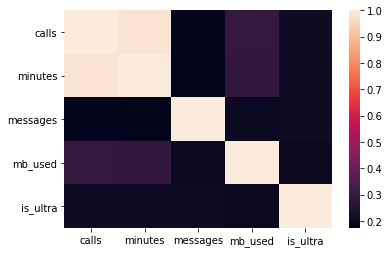

In [5]:
sns.heatmap(users.corr());

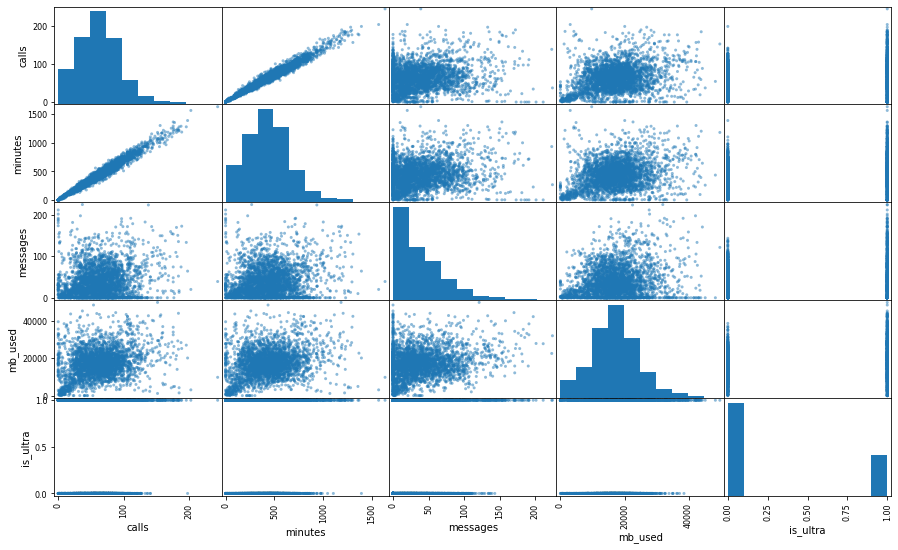

In [6]:
pd.plotting.scatter_matrix(users, figsize=(15, 9));

Мы видим, что 2 признака - calls и minutes имеют большой коэф. корреляции. Было бы логично оставить один признак из двух, например <b>minutes.</b>

Остальные признаки имеют коэф. корреляции ниже 0.5

## Разделение данных на выборки

In [7]:
features = users.drop(['is_ultra', 'calls'], axis=1)
target = users['is_ultra']

features_train, features_remain, target_train, target_remain = train_test_split(
    features, target, train_size=0.6, random_state=123, stratify=target
)

In [8]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_remain, target_remain, train_size=0.5, random_state=123, stratify=target_remain
)

Мы разделили данные на:

 - Обучающую выборку: features_train, target_train - 60%
 
 - Валидационную выборку: features_valid, target_valid - 20%
 
 - Тестовую выборку: features_test, target_test - 20%

## Исследование моделей

В первую очередь необходимо определить, что перед нами стоит задача <b>классификации.</b>

### DesicionTree

Начнем с исследования модели DesicionTree, меняя ее гиперпараметр - max_depth от 1 до 10.

In [9]:
best_model = None
best_result = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=123, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    if result > best_result:
        best_model_des_tree = model
        best_result = result
        best_depth = depth

accuracy_des_tree = best_result
print("Accuracy лучшей модели:", best_result)
print("С глубиной дерева:", best_depth)

Accuracy лучшей модели: 0.7947122861586314
С глубиной дерева: 3


Наилучшим решающим деревом оказалось дерево с глубиной 3, ее точность составила 0.79.

### RandomForest

Теперь исследуем модель RandomForest, меняя ее гиперпараметры: n_estimators и max_depth.

In [10]:
for est in range(10, 51, 10):
    for depth in range (6, 11):
        for split in range(4, 7):
            for leaf in range(2, 6):
                model = RandomForestClassifier(random_state=123, n_estimators=est, max_depth=depth,
                                              min_samples_split=split, min_samples_leaf=leaf)
                model.fit(features_train, target_train)
                predictions_valid = model.predict(features_valid)
                result = accuracy_score(target_valid, predictions_valid)
                if result > best_result:
                    best_model_rand_forest = model
                    best_result = result
                    best_est = est
                    best_depth = depth
                    best_min_samples_split = split
                    best_min_samples_leaf = leaf

accuracy_rand_forest = best_result
print("Accuracy наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth,
      "Минимальное число объектов:", best_min_samples_split, "Минимальное число объектов в листьях", best_min_samples_leaf, sep='\n')

Accuracy наилучшей модели на валидационной выборке:
0.8118195956454122
Количество деревьев:
10
Максимальная глубина:
10
Минимальное число объектов:
5
Минимальное число объектов в листьях
2


Лучшая модель Случайного Леса показала результат лучше: точность 0.81 при количестве деревьев = 10, с максимальной глубиной = 10, минимальным числом объектов = 5 и минимальным числом объектов в листьях = 2

### LogisticRegression

Также исследуем модель Логистической Регрессии.

In [11]:
model = LogisticRegression(random_state=123)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = accuracy_score(target_valid, predictions)
best_model_log_reg = model

accuracy_log_reg = result
print("Accuracy модели логистической регрессии на валидационной выборке:", result)

Accuracy модели логистической регрессии на валидационной выборке: 0.6967340590979783


Логистическая регрессия не показала высокой точности.

<b>Вывод:</b> наилучший результат на валидационной выборке показала модель Случайного Леса, ее и будем проверять на тестовой выборке.

## Проверьте модель на тестовой выборке

In [12]:
features_train_valid = features_train.append(features_valid)
target_train_valid = target_train.append(target_valid)

predictions_train = best_model_rand_forest.predict(features_train)
predictions_valid = best_model_rand_forest.predict(features_valid)
predictions_test = best_model_rand_forest.predict(features_test)
print("Accuracy модели RandomForest на обучающей выборке:", accuracy_score(target_train, predictions_train))
print("Accuracy модели RandomForest на валидационной выборке:", accuracy_score(target_valid, predictions_valid))
best_model_rand_forest.fit(features_train_valid, target_train_valid)
predictions_train_valid = best_model_rand_forest.predict(features_train_valid)
print("Accuracy модели RandomForest на обучающей + валидационной выборке:", accuracy_score(target_train_valid, predictions_train_valid))
print("Accuracy модели RandomForest на тестовой выборке:", accuracy_score(target_test, predictions_test))

Accuracy модели RandomForest на обучающей выборке: 0.8495850622406639
Accuracy модели RandomForest на валидационной выборке: 0.8118195956454122
Accuracy модели RandomForest на обучающей + валидационной выборке: 0.852975495915986
Accuracy модели RandomForest на тестовой выборке: 0.8258164852255054


## Проверка моделей на адекватность

In [14]:
from sklearn.dummy import DummyClassifier
dummy_model = DummyClassifier(random_state=123, strategy='most_frequent')
dummy_model.fit(features_train_valid, target_train_valid)
dummy_predictions = dummy_model.predict(features_test)
print('Accuracy простейшей модели: ', accuracy_score(target_test, dummy_predictions))

Accuracy простейшей модели:  0.6936236391912908


In [15]:
users['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Если представить себе самую примитивную модель, которая всем записям присваивает 0 (нулевой класс), то точность такой модели будет около 70%, так как в датасете в действительности 0 (нулевых классов) именно 70%.

В сравнении с простейшей моделью (точность: 0.56) и с примитивной (точность: 0.7), точность модели RandomForest составляет 0.825, что превосходит показатели простейших модолей. Соответственно, модель - вменяема.

## Вывод

Данные были разделены на:

- Обучающую выборку: features_train, target_train - 60%
- Валидационную выборку: features_valid, target_valid - 20%
- Тестовую выборку: features_test, target_test - 20%


---------------------------------------------------------


Наилучший результат на валидационной выборке показала модель Случайного Леса. 


Точность: 0.81


Количество деревьев: 10


Максимальная глубина: 10


Минимальное число объектов: 5


Минимальное число объектов в листьях: 2

------------------------------------------------------------

<b>Метрика Accuracy модели RandomForest на тестовой выборке: 0.825</b>